In [104]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

with open('times_and_prefs.pickle', 'rb') as f:
    data = pickle.load(f)

In [45]:
data.keys()

dict_keys(['free_times', 'prefs', 'talk_clusters', 'talk_interestingness'])

Text(0, 0.5, 'Audience')

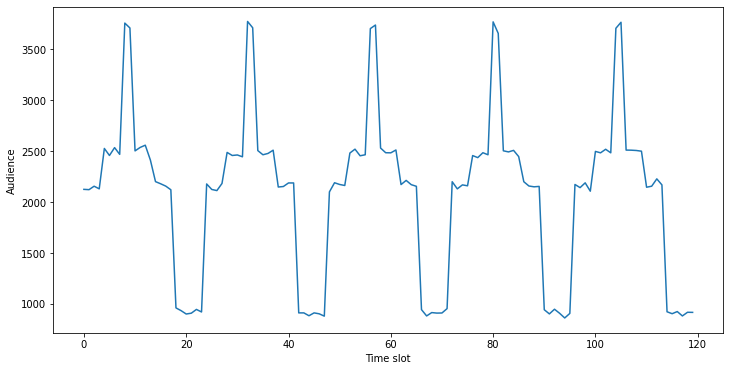

In [39]:
# Reduce free times to a distribution across all people.
A = np.zeros((len(data['free_times']), 24*5))
for i, free_time in enumerate(data['free_times']):
    A[i, free_time] = 1

audience = A.sum(0)
plt.figure(figsize=(12, 6))
plt.plot(audience)
plt.xlabel('Time slot')
plt.ylabel('Audience')

Baseline algorithm:
* For each cluster, repeat until a specified number of slots are filled:
  * Find the most interesting talk not yet assigned
  * Assign the talk to the empty slot with the most audience that works for that talk
  * Assign two more talks within that slot (the two most interesting ones which can deal with this slot)

In [56]:
availability = A[:1000, :]

rows = []
for talk, (cluster, interestingness, avail) in enumerate(zip(data['talk_clusters'], data['talk_interestingness'], availability)):
    time_slots = np.where(avail == 1)[0]
    for time_slot in time_slots:
        rows.append(
            {'talk': talk,
            'cluster': cluster,
            'interestingness': interestingness,
            'time_slot': time_slot}
        )
df_talk = pd.DataFrame(rows)


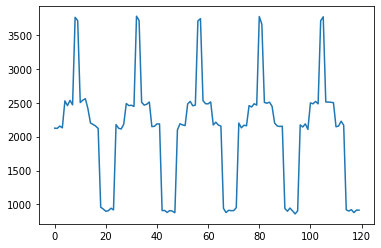

In [150]:
plt.plot(audience)

In [155]:
df_talk['assignment'] = -1

slots = []
res_audience = audience.copy()

for cluster in range(10):
    for i in range(15):
        # Figure out the headliner for a given slot first.
        df_c = df_talk.query(f'cluster == {cluster}')
        i_level = df_c.query('assignment == -1').interestingness.max()
        tgt = df_c.query(f'interestingness == {i_level}')
        time_slots = tgt.time_slot

        target_slot = time_slots.iloc[res_audience[time_slots].argmax()]
        slots.append(target_slot)

        # Assume we have a maximal audience capture of 2/3.
        res_audience[target_slot] *= 2/3

        df_talk.loc[(df_talk.talk == tgt.iloc[0].talk), 'assignment'] = target_slot

        # Figure out the warmup acts for this slot
        df_avail = df_talk.query(f'cluster == {cluster} and assignment == -1 and time_slot == {target_slot}')
        tops = sorted(df_avail.interestingness)[::-1][:2]
        if len(tops) != 2:
            print("Not enough availability in this slot")
        for t in tops:
            the_talk = df_avail.query(f'interestingness == {t}').talk.iloc[0]
            df_talk.loc[(df_talk.talk == the_talk), 'assignment'] = target_slot

In [156]:
df_assignments = df_talk.groupby('talk').first().reset_index()
df_assignments['assigned'] = df_assignments['assignment'] != -1
df_assignments.assigned.sum()

450

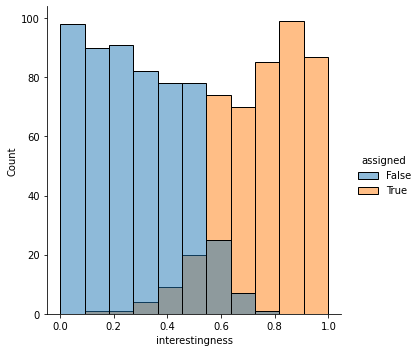

In [153]:
sns.displot(data=df_assignments, x='interestingness', hue='assigned')

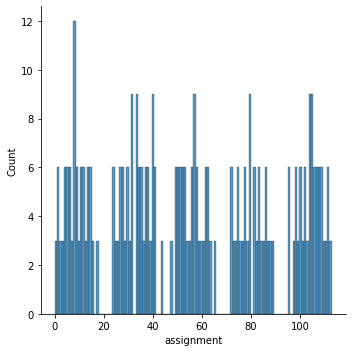

In [157]:
sns.displot(df_assignments.query('assignment != -1'), x='assignment', bins=24*5)